In [1]:
import librosa
import matplotlib.pyplot as plt
import medleydb as mdb
from medleydb.mix import VOCALS
import motif
from motif.core import Contours
from motif import plot
import numpy as np
import os
from pprint import pprint
import random
import scipy

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cd ../../experiment-scripts/

/Users/bittner/Dropbox/MARL/repos/aes-semantic-audio-2016/experiment-scripts


In [3]:
import utils

In [4]:
SR = 44100.0/256.0
HOP = (1.0/SR) + 0.0001 
F_THRESH = 1.0/24.0
# MDB_MIXES = "/Users/rabitt/Dropbox/MARL/mono"
INTERPOLATORS = {}
FTR = motif.run.get_features_module('bitteli')

In [5]:
class MockEtr(motif.core.ContourExtractor):
    @property
    def audio_samplerate(self):
        """Property to get the sample rate of the output contours"""
        return 44100

    @property
    def sample_rate(self):
        """Property to get the sample rate of the output contours"""
        return SR

    @property
    def min_contour_len(self):
        """Property to get the minimum length of a contour in seconds"""
        return 0.05

    @classmethod
    def get_id(cls):
        """Method to get the id of the extractor type"""
        return 'mock'

    def compute_contours(self, audio_filepath):
        """Method for computing features for given audio file"""
        pass

In [6]:
ETR = MockEtr()

In [7]:
def get_contours(trackid_list):
    contour_list = []
    instrument_list = []
    component_list = []
    contour_trackids = []
    contour_stemids = []
    for trackid in trackid_list:
        
        print trackid
        mtrack = mdb.MultiTrack(trackid)
        
        for i, stem in mtrack.stems.items():
            data = stem.pitch_annotation
            
            if data is None:
                data = stem.pitch_estimate_pyin

            if data is not None:
                print "    > {}".format(stem.instrument)

                if stem.component == 'bass':
                    conf_interp = lambda x: 1.0
                else:
                    conf_interp = utils.activation_conf_interpolator(mtrack, i)                    
                
                if trackid not in INTERPOLATORS.keys():
                    INTERPOLATORS[trackid] = utils.salience_interpolator(mtrack.mix_path)

                ctr = utils.pitch_to_contours(data, INTERPOLATORS[trackid], conf_interp, mtrack.mix_path, n_harmonics=8)
                contour_list.append(ctr)
                instrument_list.append(stem.instrument)
                component_list.append(stem.component)
                contour_trackids.append(trackid)
                contour_stemids.append(i)

    return contour_list, instrument_list, component_list, contour_trackids, contour_stemids

In [8]:
def get_vocal_label_dict(train_labels, test_labels, vocal_list):
    labels = list(set(train_labels + test_labels))
    label_dict = {lab: int(lab in vocal_list) for lab in labels}
    return label_dict

def get_melody_label_dict(train_labels, test_labels):
    labels = list(set(train_labels + test_labels))
    label_dict = {lab: int(lab == 'melody') for lab in labels}
    return label_dict

def get_bass_label_dict(train_labels, test_labels):
    labels = list(set(train_labels + test_labels))
    label_dict = {lab: int(lab == 'bass') for lab in labels}
    return label_dict

def get_inst_label_dict(train_labels, test_labels):
    labels = list(set(train_labels + test_labels))
    label_dict = {lab: i for i, lab in enumerate(labels)}
    return label_dict, labels

In [9]:
def build_training_testing_set(train_contours, train_labels, test_contours, test_labels,
                               label_dict):
    X_train = []
    Y_train = []
    for ctr, label in zip(train_contours, train_labels):
        label_idx = label_dict[label]
        feature = FTR.compute_all(ctr)
        X_train.append(feature)
        Y_train.append([label_idx]*len(ctr.nums))

    X_test = []
    Y_test = []
    for ctr, label in zip(test_contours, test_labels):
        label_idx = label_dict[label]
        feature = FTR.compute_all(ctr)
        X_test.append(feature)
        Y_test.append([label_idx]*len(ctr.nums))
    
    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    Y_train = np.concatenate(Y_train)
    Y_test = np.concatenate(Y_test)
    
    return X_train, Y_train, X_test, Y_test

In [10]:
def run_exp(X_train, Y_train, X_test, Y_test, class_labels, compute_prob=True):
    
    clf = motif.contour_classifiers.RandomForest()
    clf.fit(X_train, Y_train)
    
    if compute_prob:
        Y_train_pred_prob = clf.predict(X_train)
        Y_test_pred_prob = clf.predict(X_test)
    else:
        Y_train_pred_prob = None
        Y_test_pred_prob = None
    
    Y_train_pred = clf.predict_discrete_label(X_train)
    Y_test_pred = clf.predict_discrete_label(X_test)
    
    train_score = clf.score(Y_train_pred, Y_train, Y_train_pred_prob)
    test_score = clf.score(Y_test_pred, Y_test, Y_test_pred_prob)
    
    pprint(train_score)
    pprint(test_score)
    
    plt.figure(figsize=(12, 12))
    plt.grid('off')

    plt.subplot(2, 1, 1)
    plt.title("training")
    plt.imshow(train_score['confusion matrix'], interpolation='none', cmap='hot')
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.axis('auto')
    plt.axis('tight')
    plt.colorbar()
    
    plt.subplot(2, 1, 2)
    plt.title("testing")
    plt.imshow(test_score['confusion matrix'], interpolation='none', cmap='hot')
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.axis('auto')
    plt.axis('tight')
    plt.colorbar()
    
    plt.show()
    
    plt.figure(figsize=(12, 7))
    y = clf.clf.feature_importances_
    x = np.arange(len(y))
    plt.bar(x, y)
    plt.xticks(x + 0.5, FTR.feature_names, rotation='vertical')
    plt.show()

## Build Contour Data

In [11]:
all_trackids = []
all_trackids.extend(mdb.TRACK_LIST)

data_split = mdb.utils.artist_conditional_split(
    trackid_list=all_trackids, test_size=0.2, num_splits=1, random_state=7
)

train_ids = data_split[0]['train']
test_ids = data_split[0]['test']

In [14]:
trackids = utils.get_experiment_trackids()
print(trackids)

['AClassicEducation_NightOwl', 'AimeeNorwich_Child', 'AimeeNorwich_Flying', 'AlexanderRoss_GoodbyeBolero', 'AlexanderRoss_VelvetCurtain', 'Auctioneer_OurFutureFaces', 'AvaLuna_Waterduct', 'BigTroubles_Phantom', 'BrandonWebster_YesSirICanFly', 'CelestialShore_DieForUs', 'ClaraBerryAndWooldog_AirTraffic', 'ClaraBerryAndWooldog_Stella', 'ClaraBerryAndWooldog_WaltzForMyVictims', 'Creepoid_OldTree', 'DreamersOfTheGhetto_HeavyLove', 'EthanHein_1930sSynthAndUprightBass', 'EthanHein_BluesForNofi', 'FacesOnFilm_WaitingForGa', 'Grants_PunchDrunk', 'HeladoNegro_MitadDelMundo', 'HezekiahJones_BorrowedHeart', 'HopAlong_SisterCities', 'InvisibleFamiliars_DisturbingWildlife', 'KarimDouaidy_Hopscotch', 'KarimDouaidy_Yatora', 'LizNelson_Coldwar', 'LizNelson_Rainfall', 'Lushlife_ToynbeeSuite', 'MatthewEntwistle_AnEveningWithOliver', 'MatthewEntwistle_DontYouEver', 'MatthewEntwistle_FairerHopes', 'MatthewEntwistle_ImpressionsOfSaturn', 'MatthewEntwistle_TheArch', 'MatthewEntwistle_TheFlaxenField', 'Meaxi

In [13]:
(train_contours, train_instrument_labels,
 train_component_labels, train_trackid) = get_contours(train_ids)
(test_contours, test_instrument_labels,
 test_component_labels, test_trackid) = get_contours(test_ids)

AClassicEducation_NightOwl
    > distorted electric guitar
    > male singer
    > male singer
AimeeNorwich_Child
    > female singer
AimeeNorwich_Flying
    > clean electric guitar
    > clean electric guitar
    > clarinet
AmarLal_Rest
    > clean electric guitar
AmarLal_SpringDay1
    > acoustic guitar
Auctioneer_OurFutureFaces
    > horn section
    > male singer
AvaLuna_Waterduct
    > male singer
BigTroubles_Phantom
    > male singer
    > distorted electric guitar
BrandonWebster_DontHearAThing
    > female singer
BrandonWebster_YesSirICanFly
    > male singer
CelestialShore_DieForUs
    > male singer
    > female singer
    > tack piano
    > clean electric guitar
ChrisJacoby_BoothShotLincoln
    > mandolin
ChrisJacoby_PigsFoot
    > mandolin
ClaraBerryAndWooldog_AirTraffic
    > clean electric guitar
    > female singer
ClaraBerryAndWooldog_Boys
    > piano
    > female singer
    > tenor saxophone
ClaraBerryAndWooldog_Stella
    > female singer
ClaraBerryAndWooldog_TheBadGuys


## Vocal non-vocal

{'accuracy': 1.0,
 'auc score': 0.99999999999999989,
 'confusion matrix': array([[26040,     0],
       [    0, 11003]]),
 'f1': array([ 1.,  1.]),
 'mcc': 1.0,
 'precision': array([ 1.,  1.]),
 'recall': array([ 1.,  1.]),
 'support': array([26040, 11003])}
{'accuracy': 0.8814016172506739,
 'auc score': 0.94480767363502971,
 'confusion matrix': array([[5804,  726],
       [ 286, 1717]]),
 'f1': array([ 0.91980983,  0.77237967]),
 'mcc': 0.69949705685614261,
 'precision': array([ 0.95303777,  0.7028244 ]),
 'recall': array([ 0.88882083,  0.85721418]),
 'support': array([6530, 2003])}


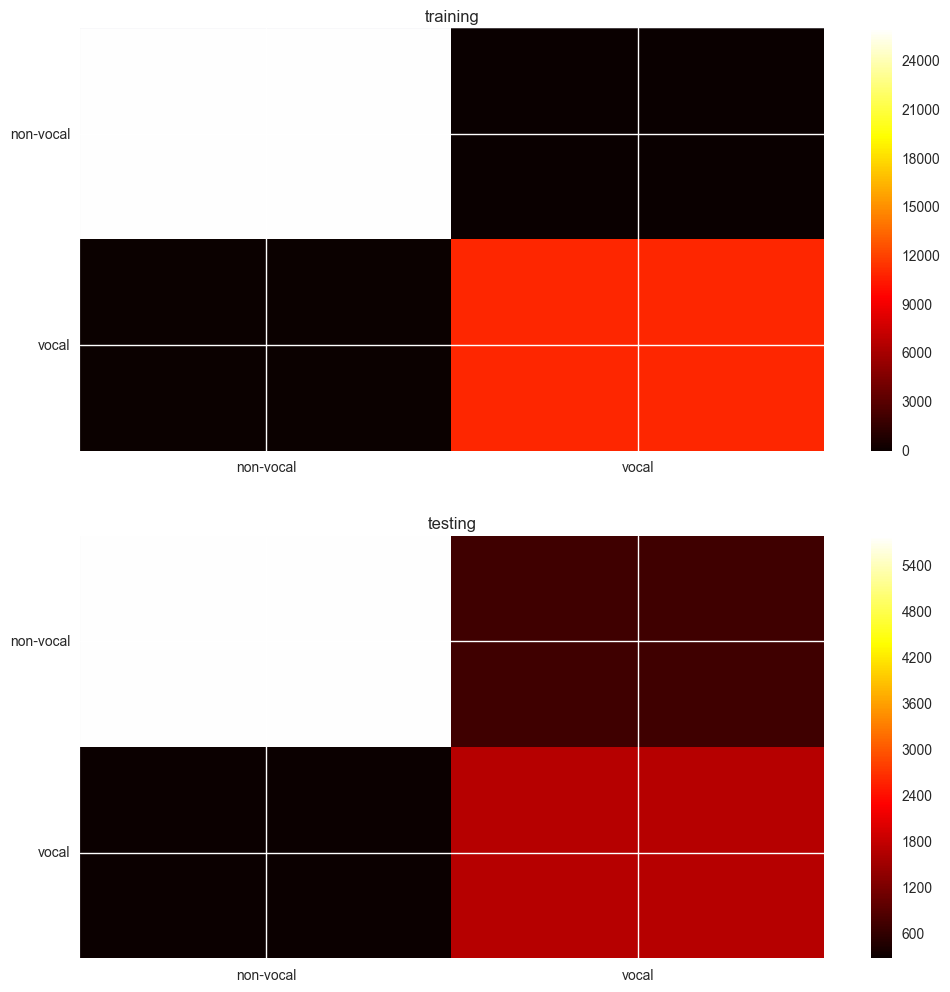

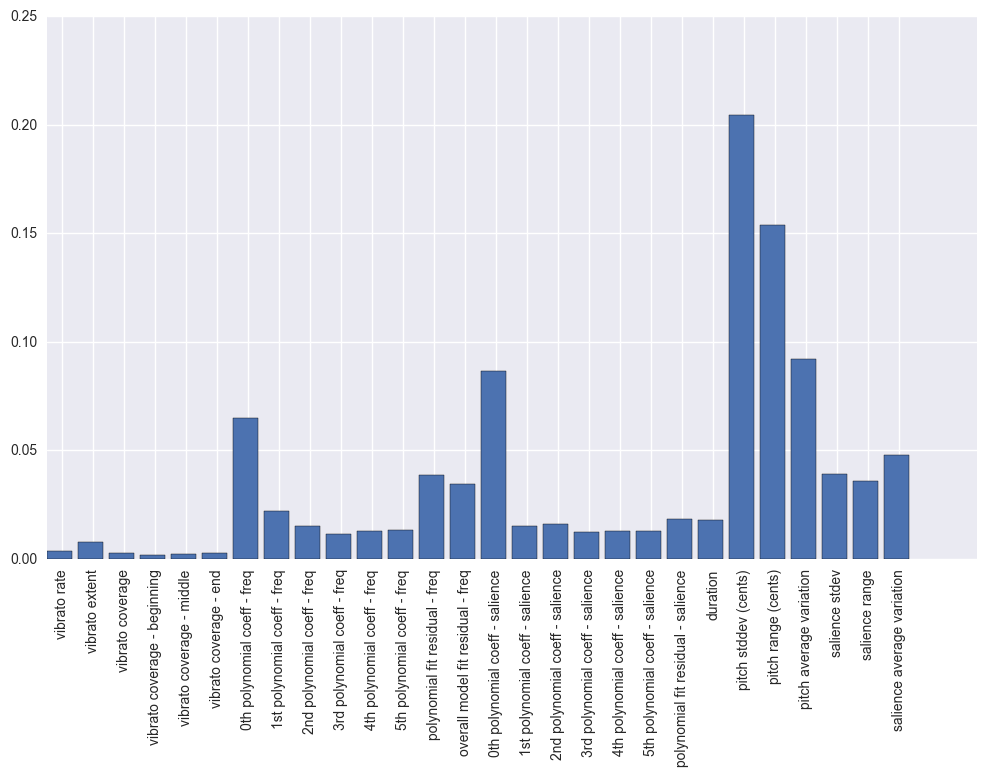

In [14]:
vocal_label_dict = get_vocal_label_dict(
    train_instrument_labels, test_instrument_labels, VOCALS
)
vocal_labels = ['non-vocal', 'vocal']
X_train, Y_train, X_test, Y_test =  build_training_testing_set(
    train_contours, train_instrument_labels,
    test_contours, test_instrument_labels,
    vocal_label_dict
)
run_exp(X_train, Y_train, X_test, Y_test, vocal_labels)

## Melody non-melody

In [ ]:
melody_label_dict = get_melody_label_dict(
    train_component_labels, test_component_labels
)
melody_labels = ['non-melody', 'melody']
X_train, Y_train, X_test, Y_test =  build_training_testing_set(
    train_contours, train_component_labels,
    test_contours, test_component_labels,
    melody_label_dict
)
run_exp(X_train, Y_train, X_test, Y_test, melody_labels)

## Bass non-bass

In [ ]:
bass_label_dict = get_bass_label_dict(
    train_component_labels, test_component_labels
)
bass_labels = ['non-bass', 'bass']
X_train, Y_train, X_test, Y_test =  build_training_testing_set(
    train_contours, train_component_labels,
    test_contours, test_component_labels,
    bass_label_dict
)
run_exp(X_train, Y_train, X_test, Y_test, bass_labels)

## Inst-ID

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.98393574297188757,
 'auc score': None,
 'confusion matrix': array([[187,   0],
       [  4,  58]]),
 'f1': array([ 0.98941799,  0.96666667]),
 'mcc': 0.95702277178334361,
 'precision': array([ 0.97905759,  1.        ]),
 'recall': array([ 1.        ,  0.93548387]),
 'support': array([187,  62])}
{'accuracy': 0.40465116279069768,
 'auc score': None,
 'confusion matrix': array([[435,   0,   0,  17,   0,   0],
       [121,   0,   0,   0,   0,   0],
       [152,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [315,   0,   0,   2,   0,   0],
       [ 33,   0,   0,   0,   0,   0]]),
 'f1': array([ 0.57692308,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'mcc': None,
 'precision': array([ 0.41193182,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'recall': array([ 0.96238938,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'support': array([452, 121, 152,   0, 317,  33])}


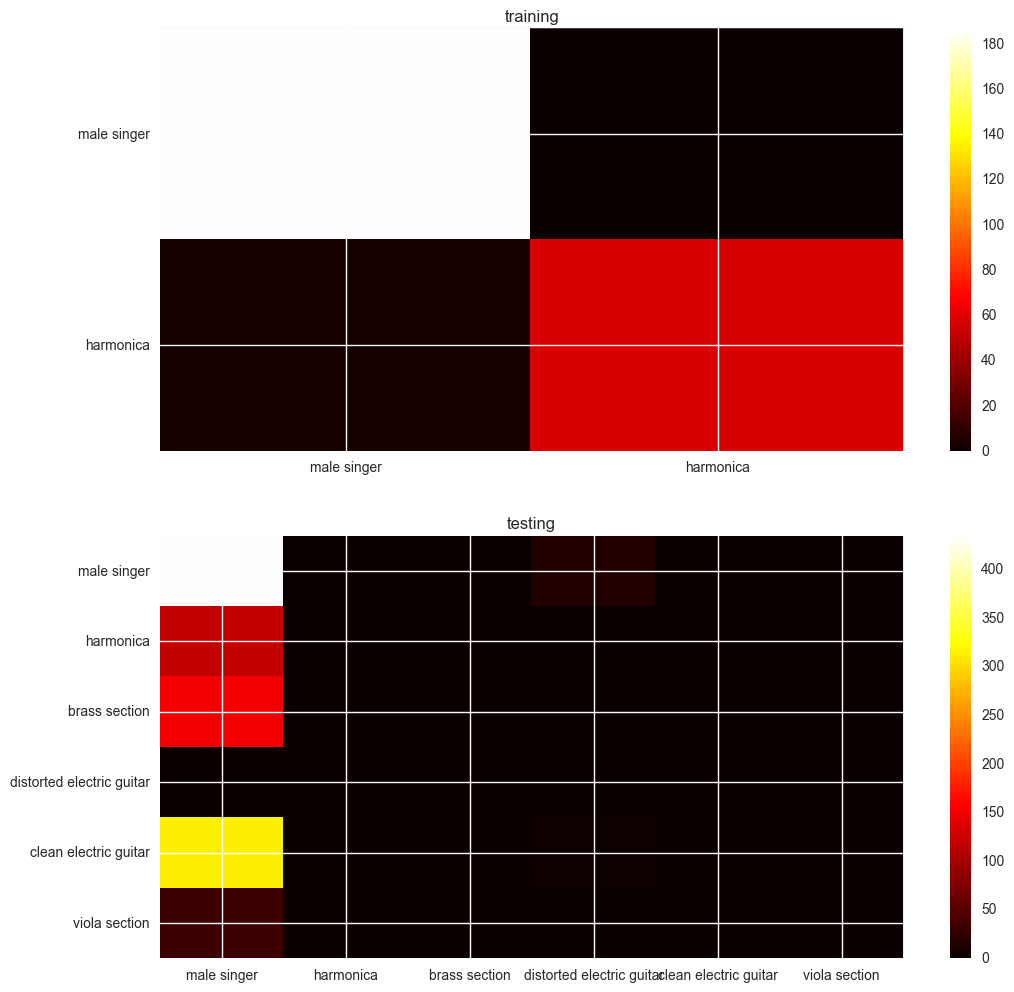

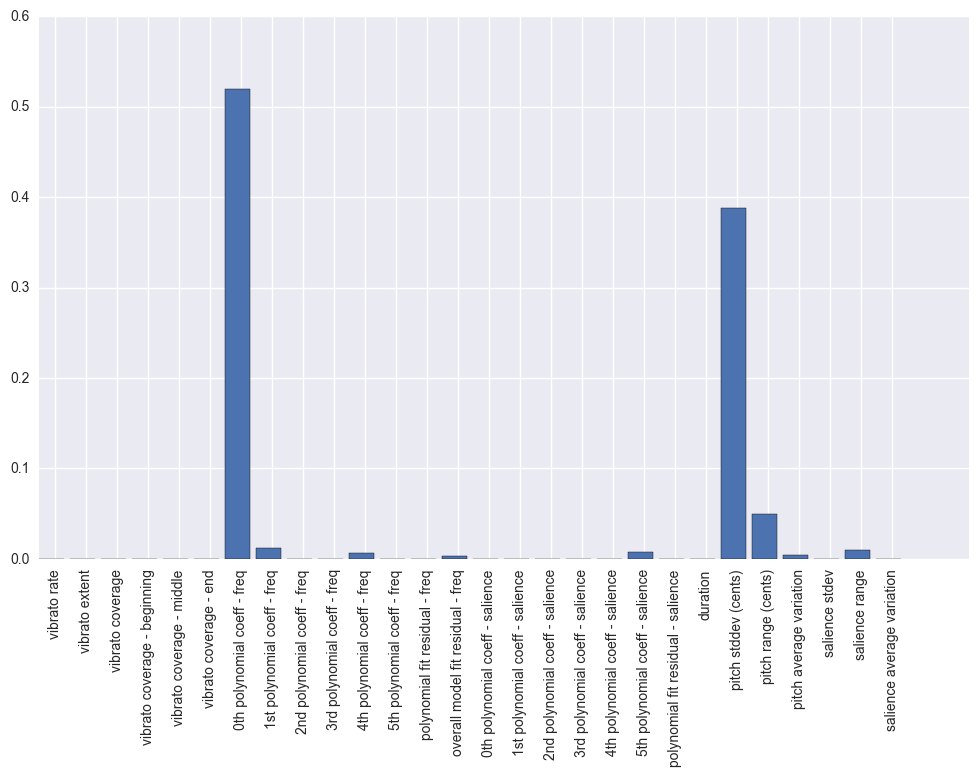

In [17]:
inst_label_dict, inst_labels = get_inst_label_dict(
    train_instrument_labels, test_instrument_labels
)
X_train, Y_train, X_test, Y_test =  build_training_testing_set(
    train_contours, train_instrument_labels,
    test_contours, test_instrument_labels,
    inst_label_dict
)
run_exp(X_train, Y_train, X_test, Y_test, inst_labels, compute_prob=False)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy
sns.set()
%matplotlib inline
# from motif import plot

In [12]:
linestyles = {'melody': '-', 'bass': '-', '': '-'}
def plot_multif0(trackid):
    contour_list, instrument_list, component_list, contour_trackids, contour_stemids = get_contours([trackid])
    colors = sns.color_palette("deep", len(contour_list) + 1)[1:]
    used_colors = []
    used_insts = []
    for n, (ctr, instrument, component) in enumerate(zip(contour_list, instrument_list, component_list)):

        used_colors.append(colors[n])
        used_insts.append(instrument)

        print(instrument)
        print(component)
        for i in ctr.nums:
            w = 1
            t = ctr.contour_times(i)
            f = ctr.contour_freqs(i)
            if component == 'bass':
                if max(t) - min(t) < 0.5:
                    continue
                f = scipy.signal.medfilt(f, 9)
            
            if instrument == ['clean electric guitar'] and max(t) < 30:
                f = 2.0 * f
                if max(t) < 15:
                    w = 2

            if instrument == ['female singer'] and component == 'melody':
                w = 2
                
            plt.semilogy(
                t,
                f,
                color=colors[n],
                linestyle=linestyles[component],
                linewidth=w,
                basey=2
            )
    plt.xlim(60, 120)
    plt.axis('tight')

    return used_colors, used_insts    

In [13]:
import os
import librosa
intervals = []
with open('../notebooks/dev/clara_piano.txt', 'r') as fhandle:
    lines = fhandle.readlines()
    for line in lines:
        intervals.append(line.strip('\n').split('\t'))
intervals = np.array(intervals, dtype=float)

In [14]:
piano_x = []
piano_y = []
for row in intervals:
    if row[1] - row[0] < 0.3:
        continue
    y = librosa.midi_to_hz(row[2])
    if y > 280 or y < 115:
        continue
    piano_x.append([row[0], row[1]])
    piano_y.append([y, y])

ClaraBerryAndWooldog_AirTraffic
    > ['electric bass']
    > ['clean electric guitar']
    > ['female singer']
    > ['female singer']
['electric bass']
bass
['clean electric guitar']
melody
['female singer']

['female singer']
melody


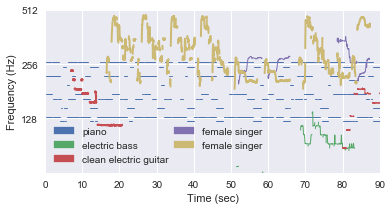

In [26]:
plt.figure(figsize=(6, 3))
c = sns.color_palette("deep", 1)[0]
for x_list, y_list in zip(piano_x, piano_y):
    plt.semilogy(x_list, y_list, color=c, basey=2, linewidth=1)
used_colors, used_insts = plot_multif0("ClaraBerryAndWooldog_AirTraffic")
plt.xlim(0, 90)
plt.ylim(64, 500)

patches = []
for color, i in zip([c] + used_colors, [['piano']] + used_insts):
    patch = mpatches.Patch(color=color, label=i[0])
    patches.append(patch)

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
    
plt.yticks([2**7, 2**8, 2**9], [2**7, 2**8, 2**9])    
plt.legend(handles=patches, loc=3, ncol=2, columnspacing=0.5)

plt.savefig('../output/multif0_diagram.pdf', format='pdf', bbox_inches='tight')

ClaraBerryAndWooldog_AirTraffic
    > ['electric bass']
    > ['clean electric guitar']
    > ['female singer']
    > ['female singer']


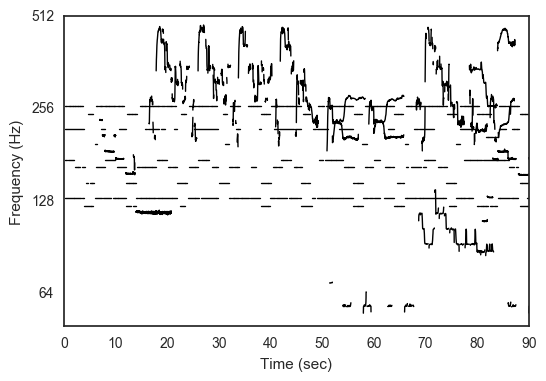

In [29]:
sns.set_style('white')
plt.figure(figsize=(6, 4))
c = 'k'
for x_list, y_list in zip(piano_x, piano_y):
    plt.semilogy(x_list, y_list, color=c, basey=2, linewidth=1)
    
    
linestyles = {'melody': '-', 'bass': '-', '': '-'}

contour_list, instrument_list, component_list, contour_trackids, contour_stemids = get_contours(["ClaraBerryAndWooldog_AirTraffic"])

for n, (ctr, instrument, component) in enumerate(zip(contour_list, instrument_list, component_list)):

    for i in ctr.nums:
        w = 1
        t = ctr.contour_times(i)
        f = ctr.contour_freqs(i)
        if component == 'bass':
            if max(t) - min(t) < 0.5:
                continue
            f = scipy.signal.medfilt(f, 9)

        if instrument == ['clean electric guitar'] and max(t) < 30:
            f = 2.0 * f

        plt.semilogy(
            t,
            f,
            color=c,
            linestyle=linestyles[component],
            linewidth=w,
            basey=2
        )

plt.xlim(60, 120)
plt.axis('tight')

plt.xlim(0, 90)
plt.ylim(50, 500)

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
    
plt.yticks([2**6, 2**7, 2**8, 2**9], [2**6, 2**7, 2**8, 2**9])    

plt.savefig('../output/pitchmap_diagram.pdf', format='pdf', bbox_inches='tight')